In [1]:
import os
import re
import nltk
import json
import pprint
import numpy as np
import pandas as pd
import pickle as pkl
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from scipy import sparse
from numpy import save, load
from keras.engine.topology import Layer
from pandas.io.json import json_normalize
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Permute, concatenate, Attention, MultiHeadAttention
pp = pprint.PrettyPrinter(indent=4, width=80, compact=False)


In [2]:
tweets = pd.read_csv("../data/HealthStory_tweets_processed.csv", lineterminator='\n', index_col=0)
health_story = pd.read_csv("../data/HealthStory.csv")
news_articles = sorted(health_story['story_review_no'])

In [3]:
tweets.head()

,tweet.created_at,tweet.entities.hashtags,tweet.entities.symbols,tweet.entities.user_mentions,tweet.id,tweet.lang,tweet.place,tweet.retweet_count,tweet.source,tweet.favorite_count,...,tweet.user.location,tweet.user.default_profile,tweet.user.default_profile_image,tweet.user_id,news_id,tweet.possibly_sensitive,username_words,description_words,user_creation_to_tweet_time_days,user_tweeting_freq_per_day
0,2010-01-27 19:46:29+00:00,[],[],[],8291515579,en,NaN,0.0,"<a href=""http://twitterfeed.com"" rel=""nofollow...",0.0,...,1,1,True,41784143,story_reviews_01660,NaN,0.000000,0.000000,0.053178,1.823518e-05
1,2010-01-27 23:32:01+00:00,[],[],[],8299477970,en,NaN,0.0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0.0,...,1,0,False,84270990,story_reviews_01660,NaN,0.000000,0.000000,0.020736,2.825444e-05
2,2010-01-28 22:51:27+00:00,[],[],[],8341905171,en,NaN,0.0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0.0,...,0,0,False,86938456,story_reviews_01660,NaN,0.142857,0.051471,0.018561,3.510424e-07
3,2010-02-03 21:07:54+00:00,[],"[{'text': 'ICAD', 'indices': [0, 5]}]",[],8603224332,en,NaN,0.0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0.0,...,1,1,False,35253833,story_reviews_01660,NaN,0.071429,0.000000,0.060346,2.638592e-04
4,2010-01-28 03:48:59+00:00,[],[],[],8308211999,en,NaN,0.0,"<a href=""http://twitterfeed.com"" rel=""nofollow...",0.0,...,0,0,False,27561937,story_reviews_01660,NaN,0.000000,0.000000,0.064569,3.024342e-05


In [4]:
tweets.columns

Index(['tweet.created_at', 'tweet.entities.hashtags', 'tweet.entities.symbols',
       'tweet.entities.user_mentions', 'tweet.id', 'tweet.lang', 'tweet.place',
       'tweet.retweet_count', 'tweet.source', 'tweet.favorite_count',
       'tweet.retweeted', 'tweet.text', 'tweet.user.description',
       'tweet.user.protected', 'tweet.user.followers_count',
       'tweet.user.friends_count', 'tweet.user.listed_count',
       'tweet.user.created_at', 'tweet.user.favourites_count',
       'tweet.user.verified', 'tweet.user.following',
       'tweet.user.statuses_count', 'tweet.user.lang', 'tweet.user.name',
       'tweet.user.geo_enabled', 'tweet.user.location',
       'tweet.user.default_profile', 'tweet.user.default_profile_image',
       'tweet.user_id', 'news_id', 'tweet.possibly_sensitive',
       'username_words', 'description_words',
       'user_creation_to_tweet_time_days', 'user_tweeting_freq_per_day'],
      dtype='object')

In [5]:
mappings = {}
for name, group in tweets.groupby('news_id'):
    mappings[name] = group['tweet.user_id'].tolist()

In [6]:
reqd_columns = [
       'tweet.user.protected',
       'tweet.user.followers_count',
       'tweet.user.friends_count',
       'tweet.user.listed_count',
       'tweet.user.favourites_count',
       'tweet.user.verified',
       'tweet.user.statuses_count',
       'tweet.user.geo_enabled',
       'tweet.user.default_profile',
       'tweet.user.default_profile_image',
       'username_words',
       'description_words',
       'user_creation_to_tweet_time_days',
       'user_tweeting_freq_per_day'
]

In [7]:
len(reqd_columns)

14

In [13]:
news_tweet_info = {}
for news in news_articles:
    news_tweet_info[news] = []
    try:
        for user in mappings[news]:
            current_user = tweets.loc[tweets['tweet.user_id'] == user]
            data = []
            if current_user.shape[0] != 0:
                for col in reqd_columns:
                    data.append(float(current_user[col].values[-1]))
            else:
                continue
            news_tweet_info[news].append(data)
    except KeyError:
        pass

In [14]:
for news in news_tweet_info.keys():
    with open(f'./tweet_user_features/{news}.pkl', 'wb') as f:
        pkl.dump(news_tweet_info[news], f)

In [8]:
freq = []
reqd_news = []
for article in news_articles:
    news = pkl.load(open(f'./tweet_user_features/{article}.pkl', 'rb'))
    freq.append(len(news))
    if len(news) > 2:
        reqd_news.append(article)

In [16]:
for i in range(300):
    print(f'I = {i} Length : {len([i for j in freq if j >= i])}')

I = 0 Length : 1639
I = 1 Length : 1632
I = 2 Length : 1627
I = 3 Length : 1622
I = 4 Length : 1618
I = 5 Length : 1615
I = 6 Length : 1610
I = 7 Length : 1607
I = 8 Length : 1604
I = 9 Length : 1598
I = 10 Length : 1591
I = 11 Length : 1586
I = 12 Length : 1579
I = 13 Length : 1569
I = 14 Length : 1562
I = 15 Length : 1557
I = 16 Length : 1549
I = 17 Length : 1545
I = 18 Length : 1539
I = 19 Length : 1532
I = 20 Length : 1525
I = 21 Length : 1517
I = 22 Length : 1507
I = 23 Length : 1499
I = 24 Length : 1493
I = 25 Length : 1480
I = 26 Length : 1474
I = 27 Length : 1464
I = 28 Length : 1459
I = 29 Length : 1452
I = 30 Length : 1445
I = 31 Length : 1434
I = 32 Length : 1426
I = 33 Length : 1423
I = 34 Length : 1417
I = 35 Length : 1408
I = 36 Length : 1399
I = 37 Length : 1393
I = 38 Length : 1390
I = 39 Length : 1375
I = 40 Length : 1370
I = 41 Length : 1365
I = 42 Length : 1358
I = 43 Length : 1348
I = 44 Length : 1340
I = 45 Length : 1335
I = 46 Length : 1332
I = 47 Length : 1324
I 

In [17]:
np.median(np.array(freq))

118.0

In [18]:
np.mean(np.array(freq))

211.63453325198293

In [9]:
graph_tweet_data = []
tweet_user_size = 64   #can change this
for news in reqd_news:
    data = pkl.load(open(f'./tweet_user_features/{news}.pkl', 'rb'))
    if len(data) >= tweet_user_size:
        graph_tweet_data.append(data[:tweet_user_size])
    else:
        data = np.asarray(data)
        random_ = data[np.random.choice(data.shape[0], tweet_user_size, replace=True),:]
        random_ = random_.tolist()
        data = data.tolist()
        data.extend(random_)
        graph_tweet_data.append(data[:tweet_user_size])
save('graph_tweet_data.npy', graph_tweet_data)

In [10]:
cosine_sim_user_adj_mat = []  # Cosine, euclidean, manhattan, average distance, weighted euclidean
for user_adj_mat in graph_tweet_data:   
    user_adj_mat =  np.array(user_adj_mat)
    user_adj_mat = sparse.csr_matrix(user_adj_mat)
    user_adj_mat = cosine_similarity(user_adj_mat)
    cosine_sim_user_adj_mat.append(user_adj_mat)                    # Contains the adjaceny matrix for each news article
save('cosine_similarity_graph_tweet.npy', cosine_sim_user_adj_mat)

In [11]:
def basic_cleanup(data):
    data = data.lower()
    data = re.sub(r'^RT[\s]+', '', data)
    data = re.sub(r'https?:\/\/.*[\r\n]*', '', data)
    data = re.sub(r'#', '', data)
    data = re.sub(r'[0-9]', '', data)
    data = re.sub(r'@[a-zA-Z0-9_]*', '', data)
    data = re.sub(r':', '', data)
    data = re.sub(r'[,.\'“-]', '', data)
    return data

In [22]:
tweet_texts_required = [] 
for news in reqd_news:
    tweet_ = tweets.loc[tweets['news_id'] == news]['tweet.text'].values[0]
    tweet_texts_required.append(basic_cleanup(tweet_))

tweet_texts_required_file = open('tweet_texts_required.pkl', 'wb')
pkl.dump(tweet_texts_required, tweet_texts_required_file)

Median lenth of text (retweet):  12.0


(array([ 37., 220., 607., 326., 230., 189.,  11.,   1.,   0.,   1.]),
 array([ 1. ,  4.8,  8.6, 12.4, 16.2, 20. , 23.8, 27.6, 31.4, 35.2, 39. ]),
 <BarContainer object of 10 artists>)

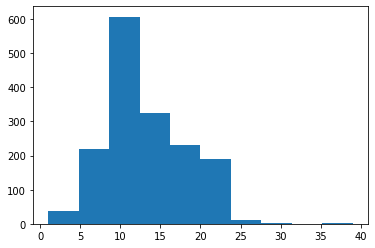

In [12]:
f = open("./tweet_texts_required.pkl", "rb")
tweet_texts = pkl.load(f)
sequence_len = np.asarray(list(map(lambda x: len(x.split(' ')), tweet_texts)))
print("Median lenth of text (retweet): ", np.median(sequence_len))
plt.hist(sequence_len)

In [13]:
tokenizer = Tokenizer()
tokens = tokenizer.fit_on_texts(tweet_texts)
sequences = tokenizer.texts_to_sequences(tweet_texts)
padded = pad_sequences(sequences, maxlen=14, padding='post')  # maxlen can be changed based on the plot above
save('tweet_padded_token.npy', padded)

In [14]:
reviews = pd.read_csv('../data/HealthStory_reviews.csv')
reviews['verdict'] = reviews['rating'].apply(lambda x: int(x >= 3))
labels = []
for news in reqd_news:
    current_review = reviews[reviews['news_id'] == news]['verdict'].values[0]
    labels.append(current_review)
save('news_labels.npy', labels)

In [3]:
def normalize_adj_numpy(adj, symmetric=True):
    if symmetric:
        d = np.diag(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)
        a_norm = adj.dot(d).transpose().dot(d)
    else:
        d = np.diag(np.power(np.array(adj.sum(1)), -1).flatten(), 0)
        a_norm = d.dot(adj)
    return a_norm

def preprocess_adj_tensor(adj_tensor, symmetric=True):
    adj_out_tensor = []
    for i in range(adj_tensor.shape[0]):
        adj = adj_tensor[i]
        adj = adj + np.eye(adj.shape[0])
        adj = normalize_adj_numpy(adj, symmetric)        
        adj_out_tensor.append(adj)
    adj_out_tensor = np.array(adj_out_tensor)
    return adj_out_tensor

def graph_conv_op(x, num_filters, graph_conv_filters, kernel):

    if len(x.get_shape()) == 2:
        conv_op = K.dot(graph_conv_filters, x)
        conv_op = tf.split(conv_op, num_filters, axis=0)
        conv_op = K.concatenate(conv_op, axis=1)
    elif len(x.get_shape()) == 3:
        conv_op = K.batch_dot(graph_conv_filters, x)
        conv_op = tf.split(conv_op, num_filters, axis=1)
        conv_op = K.concatenate(conv_op, axis=2)
    else:
        raise ValueError('x must be either 2 or 3 dimension tensor'
                         'Got input shape: ' + str(x.get_shape()))

    conv_out = K.dot(conv_op, kernel)
    return conv_out

In [4]:
len(tokenizer.word_index)

NameError: name 'tokenizer' is not defined

In [5]:
num_filters = 1                  # we should not be able to change this
source_tweet_output_dim=64       #  
source_tweet_length=14           # obtained from the plot in cell 12
number_of_feature=14             # same as reqd columns
filter_size=3                     
output_dim=64                  
vocab_size = 4050                # Used in word embeddings module
tweet_user_size = 64             # obtained from the 1st plot
GCN_output_dim = 8               # Initializing Mulitgraphcnn


In [6]:
class MultiGraphCNN(Layer):

    def __init__(self,
                 output_dim,
                 num_filters,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',  # can be changed
                 bias_initializer='zeros',             # can be changed
                 kernel_regularizer=None,              # can be changed
                 bias_regularizer=None,                # can be changed
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(MultiGraphCNN, self).__init__(**kwargs)

        self.output_dim = output_dim
        self.num_filters = num_filters
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_initializer.__name__ = kernel_initializer
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

    def build(self, input_shape):

        if self.num_filters != int(input_shape[1][-2]/input_shape[1][-1]):
            raise ValueError('num_filters does not match with graph_conv_filters dimensions.')

        self.input_dim = input_shape[0][-1]
        kernel_shape = (self.num_filters * self.input_dim, self.output_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.output_dim,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True

    def call(self, inputs):

        output = graph_conv_op(inputs[0], self.num_filters, inputs[1], self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = (input_shape[0][0], input_shape[0][1], self.output_dim)
        return output_shape

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'num_filters': self.num_filters,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)  
        }
        base_config = super(MultiGraphCNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
similarity_matrix = load('cosine_similarity_graph_tweet.npy')
graph_conv_filters = preprocess_adj_tensor(similarity_matrix)

In [8]:
y = load('news_labels.npy')
padded_docs = load('tweet_padded_token.npy')
graph_retweet_data = load('graph_tweet_data.npy')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(graph_retweet_data, y, test_size=0.3, random_state=54)
WX_train, WX_test, y_train, y_test = train_test_split(padded_docs, y, test_size=0.3, random_state=54 )
MX_train, MX_test, y_train, y_test = train_test_split(graph_conv_filters, y, test_size=0.3, random_state=54)

In [10]:
source_tweet_output_dim = 128 # can be changed

In [11]:
winput = tf.keras.layers.Input(shape=(source_tweet_length,))
wembed = tf.keras.layers.Embedding(
    vocab_size,
    source_tweet_output_dim,
    input_length = source_tweet_length,
    embeddings_initializer='glorot_uniform', # can be changed 
    embeddings_regularizer='l1_l2',          # can be changed   
     )(winput)
wembed = tf.keras.layers.GRU(source_tweet_output_dim, return_sequences=True)(wembed)

In [12]:
# rmain stores the user feature matrix
rmain_input = tf.keras.layers.Input(shape=(tweet_user_size, number_of_feature))

In [13]:
graph_conv_filters_input = tf.keras.layers.Input(shape=(tweet_user_size, tweet_user_size))
gmain_input= MultiGraphCNN(GCN_output_dim, num_filters)([rmain_input, graph_conv_filters_input])
#gmain_input= MultiGraphCNN(GCN_output_dim, num_filters)([gmain_input, graph_conv_filters_input])

In [14]:
layer = MultiHeadAttention(num_heads=10, key_dim=2, value_dim=2, dropout=0.3, attention_axes=(1,2))
output_tensor, weights = layer(wembed, gmain_input, 
                               return_attention_scores=True)

In [15]:
#dropout layers can be added
x=tf.keras.layers.Dense(output_dim,activation="relu")(output_tensor)
x=tf.keras.layers.Dense(output_dim,activation="relu")(x)
prediction= tf.keras.layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.Model([winput, rmain_input, graph_conv_filters_input],prediction)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 14, 128)      518400      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 14)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64, 64)]     0                                            
______________________________________________________________________________________________

In [16]:
Adam= tf.keras.optimizers.Adam(lr=0.001, beta_1=0.7, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, verbose=2)
model.compile(optimizer=Adam ,loss="binary_crossentropy", metrics=['accuracy'])


In [17]:
history=model.fit([np.array(WX_train),np.array(X_train),np.array(MX_train)],np.array(y_train),epochs=40,validation_split=0.3, callbacks =[early_stopping], verbose=1)


Epoch 1/40


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node Adam/Adam/update/ResourceApplyAdam/_77}}]]
	 [[Adam/gradients/AddN_4/_74]] [Op:__inference_train_function_4328]

Function call stack:
train_function


In [ ]:
scores=model.evaluate([np.array(WX_test),np.array(X_test),np.array(MX_test)],np.array(y_test), verbose=1)